In [123]:
#Packages##
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import scipy, pylab
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pandas import Series, DataFrame
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
%matplotlib inline
import seaborn; seaborn.set()
import pandas as pd
from fbprophet import Prophet
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import boxcox
from fbprophet.diagnostics import cross_validation

# Read data, data by March29th

In [94]:
##Read Data##
virus_19 = pd.read_csv('COVID-19-geographic-disbtribution-worldwide-2020-03-29 copy.csv',header=0)
virus_19.head()

,dateRep,day,month,year,cases,deaths,week,countriesAndTerritories,geoId
0,12/31/19,31,12,2019,0,0,53,Afghanistan,AF
1,12/31/19,31,12,2019,0,0,53,Algeria,DZ
2,12/31/19,31,12,2019,0,0,53,Armenia,AM
3,12/31/19,31,12,2019,0,0,53,Australia,AU
4,12/31/19,31,12,2019,0,0,53,Austria,AT


In [95]:
virus_19 = virus_19.rename(columns={"countriesAndTerritories": "Country"})
virus_19.head()

,dateRep,day,month,year,cases,deaths,week,Country,geoId
0,12/31/19,31,12,2019,0,0,53,Afghanistan,AF
1,12/31/19,31,12,2019,0,0,53,Algeria,DZ
2,12/31/19,31,12,2019,0,0,53,Armenia,AM
3,12/31/19,31,12,2019,0,0,53,Australia,AU
4,12/31/19,31,12,2019,0,0,53,Austria,AT


# Shows the details about mean, std, 25%, 50%, 75% and maximum

In [96]:
#Review the Distribution data Cases Confirmed vrs Deaths | Show Detail##
virus_19.describe()

,day,month,year,cases,deaths
count,7515.000000,7515.000000,7515.000000,7515.000000,7515.000000
mean,17.143979,2.268929,2019.991084,87.443779,4.052029
std,8.439156,1.245780,0.094006,659.254504,38.319821
min,1.000000,1.000000,2019.000000,-9.000000,0.000000
25%,10.000000,1.000000,2020.000000,0.000000,0.000000
50%,18.000000,2.000000,2020.000000,0.000000,0.000000
75%,24.000000,3.000000,2020.000000,6.000000,0.000000
max,31.000000,12.000000,2020.000000,19979.000000,971.000000


In [97]:
virus_19 = virus_19.drop(["day", "month", "year"], axis=1)
virus_19.head()

,dateRep,cases,deaths,week,Country,geoId
0,12/31/19,0,0,53,Afghanistan,AF
1,12/31/19,0,0,53,Algeria,DZ
2,12/31/19,0,0,53,Armenia,AM
3,12/31/19,0,0,53,Australia,AU
4,12/31/19,0,0,53,Austria,AT


# It grouped by the top 10 Countries by cases confirmed and deaths

In [98]:
plt.figure(figsize=(16,28))
summary = virus_19.groupby("Country")["cases","deaths"].sum().reset_index().sort_values(by="cases",ascending=False).reset_index(drop=True)[:10][::-1]

fig = go.Figure()
fig.add_trace(go.Bar(name='Confirmed Cases', y=list(summary["Country"]), x=list(summary["cases"]),orientation='h'))
fig.update_layout(title="Top 10 Affected Countries")
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(name='Cases', y=list(summary["Country"]), x=list(summary["cases"]),orientation='h')),
fig.add_trace(go.Bar(name='Death Cases', y=list(summary["Country"]), x=list(summary["deaths"]),orientation='h')),
fig.update_layout(barmode='stack',title="Confirmed & Deaths in Top 10 Countries")
fig.show()

<Figure size 1152x2016 with 0 Axes>

# TimeSeries, before the chart, it is needed to do some validations into the data, convert data variable, replease NaN

In [99]:
##*****TIme Series***##
# Validate Nule Data#
virus_19.loc[virus_19['cases'].isnull()]
# Review odd data : 
virus_19[virus_19['cases'].isin([np.nan, np.inf, -np.inf])]
virus_19[virus_19['deaths'].isin([np.nan, np.inf, -np.inf])]
# To convert Date to datetime :
virus_19['dateRep'] = virus_19['dateRep'].astype('datetime64[ns]')
# Replace Nan Data
virus_19['cases'] = virus_19['cases'].fillna(0)

In [100]:
virus_19.index = virus_19.dateRep
virus_19 = virus_19.resample('D').mean()

In [101]:
virus_19['12-31-2019':'03-29-2020']
# esto funcionará ver datos en un año dado:
virus_19['2020']

,cases,deaths
dateRep,,
2020-01-01,0.000000,0.000000
2020-01-02,0.000000,0.000000
2020-01-03,0.253731,0.000000
2020-01-04,0.000000,0.000000
2020-01-05,0.223881,0.000000
...,...,...
2020-03-25,208.278075,11.764706
2020-03-26,268.183246,12.701571
2020-03-27,307.912371,13.819588


In [102]:
virus_19.head()

,cases,deaths
dateRep,,
2019-12-31,0.402985,0.0
2020-01-01,0.000000,0.0
2020-01-02,0.000000,0.0
2020-01-03,0.253731,0.0
2020-01-04,0.000000,0.0


# It grouped by cases confirmed and deaths, additionally it shows the denisty of each variable, to represent the diferent  between each variable

In [134]:
grouped = virus_19.groupby('dateRep')['cases', 'deaths'].sum().reset_index()

temp = grouped.melt(id_vars="dateRep", value_vars=['cases', 'deaths'],
                 var_name='case', value_name='count')
fig = px.area(temp, x="dateRep", y="count", color='case',
             title='Cases - Total Cases: Area Plot', color_discrete_sequence = ['cyan', 'red', 'orange'], labels={'count':'Comparisons', 'date':''})
fig.show()

# It grouped by cases confirmed and deaths, to show the behavior of the virus into these 2 variables

In [109]:
grouped_virus_19 = virus_19.groupby('dateRep')['cases','deaths'].sum().reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=grouped_virus_19['dateRep'], y=grouped_virus_19['cases'],
                    mode='lines+markers',
                    name='cases'))
fig.add_trace(go.Scatter(x=grouped_virus_19['dateRep'], y=grouped_virus_19['deaths'],
                    mode='lines+markers',
                    name='death'))

fig.update_layout(
    title={
                'text': "Outcome of Cases (Cases or Death)",
})

# Prophet model, this model for this project it was focused on forecasted that only takes data as a dataframe with a ds (datestamp) and y (value we want to forecast) column. 

In [113]:
confirmed=virus_19.groupby('dateRep')['cases'].sum().to_frame().reset_index()

In [114]:
confirmed.columns = ['ds','y']
#confirmed['ds'] = confirmed['ds'].dt.date
confirmed['ds'] = pd.to_datetime(confirmed['ds'])
confirmed.tail()

,ds,y
85,2020-03-25,208.278075
86,2020-03-26,268.183246
87,2020-03-27,307.912371
88,2020-03-28,327.958974
89,2020-03-29,334.200000


# Create an instance of the Prophet class and then fit our dataframe to it

In [115]:
m = Prophet(interval_width=0.95)
m.fit(confirmed)
future = m.make_future_dataframe(periods=30)
future_confirmed = future.copy() # for non-baseline predictions later on
#future = future[future['ds'].unique()]
future

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,2019-12-31
1,2020-01-01
2,2020-01-02
3,2020-01-03
4,2020-01-04
...,...
115,2020-04-24
116,2020-04-25
117,2020-04-26
118,2020-04-27


In [116]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-12-31,-16.024683,-87.674583,54.325637
1,2020-01-01,-17.494884,-90.369482,51.899615
2,2020-01-02,2.292459,-69.588568,77.243271
3,2020-01-03,-2.640341,-73.210861,64.881563
4,2020-01-04,-2.450955,-78.516803,72.349515


# it calls predict to make a prediction and store it in the forecast dataframe

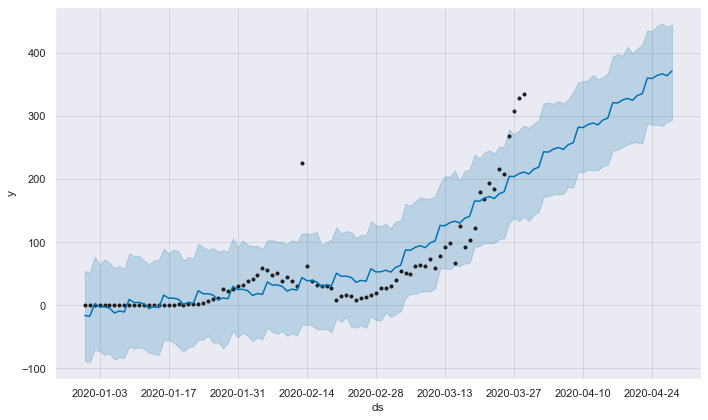

In [117]:
confirmed_forecast_plot = m.plot(forecast)

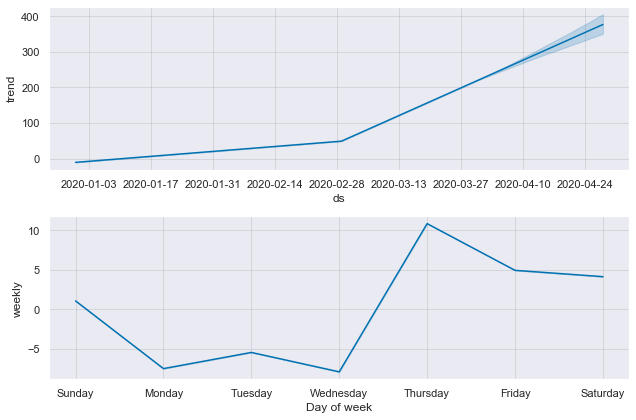

In [118]:
forecast_components = m.plot_components(forecast)

# Evaluation model

In [131]:
df_cv = cross_validation(m, initial='10 days', period='40 days', horizon = '50 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-02-08 00:00:00 and 2020-02-08 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-09,39.570054,21.005527,59.257319,39.089552,2020-02-08
1,2020-02-10,40.181489,19.099720,58.774894,44.597015,2020-02-08
2,2020-02-11,47.117887,26.491516,67.832032,38.283582,2020-02-08
3,2020-02-12,47.966119,29.195256,67.734351,30.925373,2020-02-08
4,2020-02-13,48.152714,28.375216,67.259784,226.134328,2020-02-08


In [132]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,5 days,6413.122932,80.081976,41.750539,0.336030,0.230760,0.8
1,6 days,6458.026321,80.361846,44.652757,0.381232,0.238301,0.8
2,7 days,6478.384965,80.488415,45.972287,0.419077,0.288236,0.8
3,8 days,6521.114112,80.753415,47.621217,0.478780,0.529274,0.8
4,9 days,6536.062129,80.845916,48.034728,0.492450,0.529274,0.8


# Chart the model evaluation

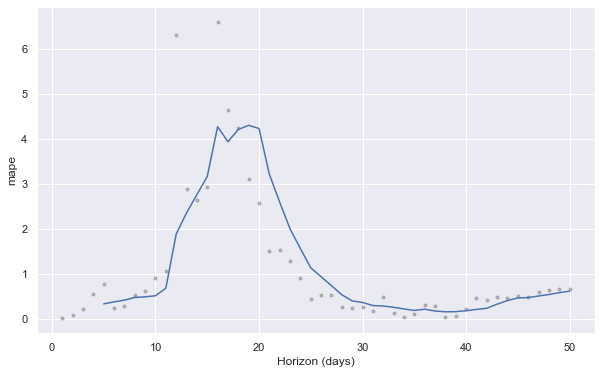

In [133]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')